# Evaluation for MapGen models

In [1]:
import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras import models
from keras.models import load_model
from keras.layers import Input
from keras.models import Model

from data_helper import readImg

def update_gan_generator_to_any_size(old_model):
    # Remove the top layer and add input with no limit
    old_model.layers.pop(0) 
    newInput = Input(shape=(None, None, 1)) # New image input
    newOutputs = old_model(newInput)
    newModel = Model(newInput, newOutputs)

    return newModel

def IoUcheck(img_input, img_output):
    # Pixelwise IoU score
    logic_and = np.sum(np.logical_and(img_output, img_input))
    logic_or = np.sum(np.logical_or(img_output, img_input))
    return logic_and/logic_or

def rescaleImg(image_arr):
    # Rescale the image to 8 x n
    if image_arr.shape[0] % 8 != 0:
        n = image_arr.shape[0] % 8
        new_x = image_arr.shape[0] - n
    else:
        new_x = image_arr.shape[0]

    if image_arr.shape[1] % 8 != 0:
        n = image_arr.shape[1] % 8
        new_y = image_arr.shape[1] - n
    else:
        new_y = image_arr.shape[1]

    image_arr = image_arr[:new_x, :new_y]

    return image_arr

def save_prediction(img, out_path, out_filename, subfix):
    fig = plt.figure(figsize=(img.shape[1] / 1000, img.shape[0] / 1000), dpi=100, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    plt.imshow(img, cmap='gray')
    fig.savefig(out_path + out_filename + subfix, dpi=1000)
    
def evaluate(image_arrA, image_arrB):
    
    target_names = ['0', '1']
    
    y_true = image_arrB.flatten().astype(bool) 
    y_pred = image_arrA.flatten().astype(bool)
        
    Accuracy = accuracy_score(y_true, y_pred)
    IntOverUnion = IoUcheck(y_true, y_pred)
    conf = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=target_names)
        
    print('Acc:', Accuracy)
    print('Error:', 1 - Accuracy)
    print('IoU:', IntOverUnion)
    print(conf)
    #print(report)

    return Accuracy, IntOverUnion, conf, report

def model_predict(newModel, input_image, num_runs):
    # Predict with model for n times
    m,n = input_image.shape
    for i in range(num_runs):
        input_image = np.reshape(input_image, (1, m, n, 1))
        input_image = newModel.predict([input_image])
        input_image = np.reshape(input_image,(m, n)) > 0.5
    return input_image

def predict_eval(SavedModel, img_range, testPath, fn_input, fn_target, out_path, scale, nr = 1):

    image_arr = readImg(testPath + fn_input)
    image_tar = readImg(testPath + fn_target)
    
    if len(img_range) == 4: # If range was set
        xmin, xmax, ymin, ymax = img_range
        image_arr = image_arr[xmin:xmax, ymin:ymax]
        image_tar = image_tar[xmin:xmax, ymin:ymax]
    
    print("- " + str(scale) +"k", 'Example: ', image_arr.shape)
    evals_orig = evaluate(image_arr, image_tar)
    
    image_arr = rescaleImg(image_arr)
    image_tar = rescaleImg(image_tar)
    
    print("+ " + str(scale) +"k", 'Prediction: ', image_arr.shape)
    pred = model_predict(SavedModel, image_arr, num_runs = nr)
    evals_pred = evaluate(pred > 0.5, image_tar)
    
    save_prediction(pred, out_path, fn_input[:-4], '_' + str(scale) + '_' + str(nr) + '_out.png')
    return [evals_orig, evals_pred]

def predict_only(SavedModel, img_range, testPath, fn_input, out_path, scale, nr = 1):

    image_arr = readImg(testPath + fn_input)
    
    if len(img_range) == 4: # If range was set
        xmin, xmax, ymin, ymax = img_range
        image_arr = image_arr[xmin:xmax, ymin:ymax]
    
    image_arr = rescaleImg(image_arr)
    
    print("+ " + str(scale) +"k", 'Prediction: ', image_arr.shape)
    pred = model_predict(SavedModel, image_arr, num_runs = nr)
    
    save_prediction(pred, out_path, fn_input[:-4], '_' + str(scale) + '_' + str(nr) + '_out.png')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
if 0: # Final GAN with ImageGAN 100 - 
    
    """
    finished and contribute to Table 1 with the numbers 1.294219, 0.613663, 0.353559
    finished and contribute to Table 2 with the numbers 0.975242, 0.819052
    """

    #scale = 25
    #modelPath = '../tmp_results/predictions/U128GAN_2019-03-17 08-40-07_25/'
    #out_evaluation = r"../tmp_results/Evaluations/ImageGAN100_25k/"
    #modelname = "model_epoch15.h5"
    
    """
    Accuracy	97.482847	98.705781	98.676250
    Error	2.517153	1.294219(1st run)	1.323750
    IoU	87.757504	93.537019	93.399459
    """
    
    #scale = 15
    #modelPath = '../tmp_results/predictions/U128GAN_2019-03-19 18-33-51_15/'
    #out_evaluation = r"../tmp_results/Evaluations/ImageGAN100_15k/"
    #modelname = "model_epoch20.h5"
    
    """
    Accuracy	98.644913	99.378125	99.386337
    Error	1.355087	0.621875	0.613663 (1st run)
    IoU	93.209151	96.833191	96.873516
    """
    
    """
    Test 1
    Accuracy	97.641310	99.024758	98.858696
    Error	2.358690	0.975242(1st run)	1.141304
    IoU	88.557903	95.191753	94.398548
    """
    
    """
    Test 2
    Accuracy	98.073852	99.180948	99.196069
    Error	1.926148	0.819052(1st run)	0.803931
    IoU	93.227646	97.079064	97.131958
    """
    
    #scale = 10
    #modelPath = '../tmp_results/predictions/U128GAN_2019-03-16 10-41-20_10/'
    #out_evaluation = r"../tmp_results/Evaluations/ImageGAN100_10k/"
    #modelname = "model_epoch29.h5"
    
    """
    Accuracy	99.260399	99.646441	99.639653
    Error	0.739601	0.353559(1st run)	0.360347
    IoU	96.226704	98.179455	98.145219
    """
    
    saved_model = models.load_model(modelPath + modelname)
    saved_model = update_gan_generator_to_any_size(saved_model)

In [10]:
if 1: # Final Residual U-net with l2 loss and Adam 0.0004
    
    """
    finished and contribute to Table 1 with the numbers 1.158906, 0.489878, 0.315556
    finished and contribute to Table 2 with the numbers 0.885039, 0.715006
    """
    
    scale = 25
    modelPath = '../tmp_results/predictions/2019-02-28 11-05-31_25/' 
    out_evaluation = r"../tmp_results/Evaluations/Runet_25k/"
    
    """
    Accuracy	97.482847	98.841094	98.794497
    Error	2.517153	1.158906	1.205503
    IoU	87.757504	94.188367	93.970965
    """
    
    #scale = 15
    #modelPath = '../tmp_results/predictions/2019-02-26 12-55-00_15/' 
    #out_evaluation = r"../tmp_results/Evaluations/Runet_15k/"
    
    """
    Accuracy	98.644913	99.510122	99.503802
    Error	1.355087	0.489878	0.496198
    IoU	93.209151	97.497501	97.465985
    
    Test 1
    Accuracy	97.641310	99.114961	99.003246
    Error	2.358690	0.885039	0.996754
    IoU	88.557903	95.629973	95.091717

    Test 2
    Accuracy	98.073852	99.284994	99.293995
    Error	1.926148	0.715006	0.706005
    IoU	93.227646	97.447957	97.481571
    """
    
    #scale = 10
    #modelPath = '../tmp_results/predictions/U128_2019-03-10 12-26-47_10/'
    #out_evaluation = r"../tmp_results/Evaluations/Runet_10k/"
    
    """
    Accuracy	99.260399	99.684444	99.678281
    Error	0.739601	0.315556	0.321719
    IoU	96.226704	98.374257	98.342913
    """

    modelname = "weights.h5"
    saved_model = load_model(modelPath + modelname)
    saved_model = update_gan_generator_to_any_size(saved_model)

In [ ]:
if 0: # Final U-net from Yu
    
    """
    finished and contribute to Table 1 with the numbers 1.357396, 0.713767, 0.495642
    finished and contribute to Table 2 with the numbers 1.115263, 0.897537
    """
        
    #scale = 25
    #modelPath = '../tmp_results/predictions/2018-07-20 07-53-50_25/'
    #out_evaluation = r"../tmp_results/Evaluations/Unet_25k/"
    
    """
    Accuracy	97.482847	98.642604	98.620330
    Error	2.517153	1.357396	1.379670
    IoU	87.757504	93.244774	93.146684
    """
    
    #scale = 15
    #modelPath = '../tmp_results/predictions/2018-07-19 13-13-22_15/'
    #out_evaluation = r"../tmp_results/Evaluations/Unet_15k/"
    
    """
    Accuracy	98.644913	99.286233	99.282378
    Error	1.355087	0.713767	0.717622
    IoU	93.209151	96.376403	96.359622

    Test 1
    Accuracy	97.641310	98.884737	98.871150
    Error	2.358690	1.115263	1.128850
    IoU	88.557903	94.528994	94.462547
    
    Test 2
    Accuracy	98.073852	99.102463	99.002376
    Error	1.926148	0.897537	0.997624
    IoU	93.227646	96.812102	96.466102
    """
    
    #scale = 10
    #modelPath = '../tmp_results/predictions/2018-07-19 15-14-38_10/'
    #out_evaluation = r"../tmp_results/Evaluations/Unet_10k/"
    
    """
    Accuracy	99.260399	99.504358	99.490938
    Error	0.739601	0.495642	0.509063
    IoU	96.226704	97.457219	97.389888
    """
    
    modelname = "weights.hdf5"
    saved_model = models.load_model(modelPath + modelname)

In [ ]:
if 0: # Final U-net from Sester
    
    # function to load a saved model - old models from sester
    def LoadModel(model_json):
        from keras.models import model_from_json
        json_file = open(model_json)
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        return loaded_model
    
    #scale = 10
    #out_evaluation = r"../tmp_results/Evaluations/Sester_10k/"
    #saved_model = LoadModel("../tmp_data/weights_sester/trainGeb10/model_ex1.json")
    #saved_model.load_weights("../tmp_data/weights_sester/trainGeb10/weights_model_ex1.h5")
    
    """
    Accuracy	99.260399	99.146684	98.942778
    Error	0.739601	0.853316	1.057222
    IoU	96.226704	95.626991	94.575020
    """
    
    #scale = 15
    #out_evaluation = r"../tmp_results/Evaluations/Sester_15k/"
    #saved_model = LoadModel("../tmp_data/weights_sester/trainGeb15/model_ex1.json")
    #saved_model.load_weights("../tmp_data/weights_sester/trainGeb15/weights_model_ex1.h5")
    
    """
    Accuracy	98.644913	99.095625	99.033403
    Error	1.355087	0.904375	0.966597
    IoU	93.209151	95.396676	95.074720

    Test 1
    Accuracy	97.641310	98.707729	98.623188
    Error	2.358690	1.292271	1.376812
    IoU	88.557903	93.605259	93.165083
    
    Test 2
    Accuracy	98.073852	98.760801	98.601671
    Error	1.926148	1.239199	1.398329
    IoU	93.227646	95.586500	95.017766
    """
    
    scale = 25
    out_evaluation = r"../tmp_results/Evaluations/Sester_25k/"
    saved_model = LoadModel("../tmp_data/weights_sester/trainGeb25/model_ex1.json")
    saved_model.load_weights("../tmp_data/weights_sester/trainGeb25/weights_model_ex1.h5")
    
    """
    Accuracy	97.482847	98.299792	98.220625
    Error	2.517153	1.700208	1.779375
    IoU	87.757504	91.499165	91.082977
    """

In [ ]:
if 0: # SRGAN 128 Input
    scale = 25
    modelPath = '../tmp_results/predictions/U128GAN_2019-03-12 21-16-58_25/'
    out_evaluation = r"../tmp_results/Evaluations/SRGAN_25k/"

    modelname = "model_epoch8.h5"
    saved_model = models.load_model(modelPath + modelname)
    saved_model = update_gan_generator_to_any_size(saved_model)

In [ ]:
if 0: # DCGAN 128 Input
    scale = 15
    modelPath = '../tmp_results/predictions/U128GAN_2019-03-12 12-30-22_15/'
    out_evaluation = r"../tmp_results/Evaluations/DCGAN_15k/"

    modelname = "model_epoch9.h5"
    saved_model = models.load_model(modelPath + modelname)
    saved_model = update_gan_generator_to_any_size(saved_model)

In [ ]:
if 0: # 256 Input 
    scale = 15
    modelPath = '../tmp_results/predictions/2019-03-09 13-18-43_15/'
    out_evaluation = r"../tmp_results/Evaluations/Runet_15k_256/"
    
    #scale = 25
    #modelPath = '../tmp_results/predictions/U256_2019-03-09 19-21-38_25/'
    #out_evaluation = r"../tmp_results/Evaluations/Runet_25k_256/"
    
    modelname = "weights.h5"
    saved_model = models.load_model(modelPath + modelname)
    saved_model = update_gan_generator_to_any_size(saved_model)

## For all scales

In [ ]:
tester_path = r"../tmp_data/Data/Testing_large/4270/"
all_records = []

In [ ]:
records = predict_eval(saved_model, [0,2400,500,2900], tester_path, r"geb_clip_4270.png", r"geb"+str(scale)+"_clip_4270.png", out_evaluation, scale, nr = 1)
all_records.extend(records)

In [ ]:
records = predict_eval(saved_model, [0,2400,500,2900], tester_path, r"geb_clip_4270.png", r"geb"+str(scale)+"_clip_4270.png", out_evaluation, scale, nr = 2)
all_records.extend(records)

In [ ]:
_records = [(acc * 100, (1-acc) * 100, iou * 100) for acc, iou, conf, report in all_records]

import pandas as pd
df = pd.DataFrame(np.transpose(_records))
df.columns = ["Input vs Target (4270)", "Prediction vs Target (4270 - 1)", 
              "Input vs Target (4270_)", "Prediction vs Target (4270 - 2)"]
df = df.rename({0: "Accuracy", 1: 'Error', 2: 'IoU'})
df.index.name = 'Metrics'
df[["Input vs Target (4270)", "Prediction vs Target (4270 - 1)", "Prediction vs Target (4270 - 2)"]]

In [ ]:
tester_path = r"../tmp_data/Data/Testing/"

predict_only(saved_model, [], tester_path, r"h1.tif", out_evaluation, scale, nr = 1)
predict_only(saved_model, [], tester_path, r"h2.tif", out_evaluation, scale, nr = 1)
predict_only(saved_model, [], tester_path, r"h3.tif", out_evaluation, scale, nr = 1)
predict_only(saved_model, [], tester_path, r"h4.tif", out_evaluation, scale, nr = 1)

In [ ]:
tester_path = r"../tmp_data/Data/"

predict_only(saved_model, [], tester_path, r"geb_clip_res.png", out_evaluation, scale, nr = 1)
predict_only(saved_model, [], tester_path, r"geb_clip_res.png", out_evaluation, scale, nr = 2)
predict_only(saved_model, [], tester_path, r"geb_clip_res.png", out_evaluation, scale, nr = 3)
predict_only(saved_model, [], tester_path, r"geb_clip_res.png", out_evaluation, scale, nr = 10)

+ 25k Prediction:  (2000, 2400)
+ 25k Prediction:  (2000, 2400)


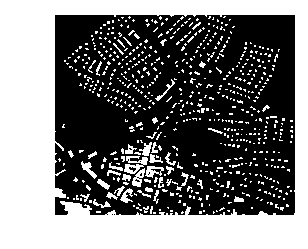

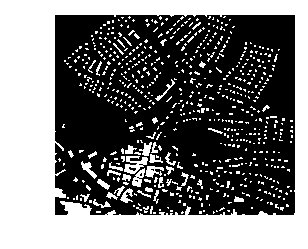

In [11]:
tester_path = r"../tmp_data/Data/"
predict_only(saved_model, [], tester_path, r"geb_test2_crop.png", out_evaluation, scale, nr = 1)
predict_only(saved_model, [], tester_path, r"geb_test2_crop.png", out_evaluation, scale, nr = 2)
#predict_only(saved_model, [], tester_path, r"Test.png", out_evaluation, scale, nr = 2)

In [ ]:
if 0: # Predict with residual u-net on chun dataset
    
    tester_path = r"../tmp_data/Data/chun/"

    predict_only(saved_model, [], tester_path, r"BW_resarea9.tif", out_evaluation, scale, nr = 2)
    predict_only(saved_model, [], tester_path, r"BW_apartbuild1.tif", out_evaluation, scale, nr = 2)
    predict_only(saved_model, [], tester_path, r"BW_industry4.tif", out_evaluation, scale, nr = 2)
    predict_only(saved_model, [], tester_path, r"BW_resarea3.tif", out_evaluation, scale, nr = 2)
    predict_only(saved_model, [], tester_path, r"BW_resarea7.tif", out_evaluation, scale, nr = 2)

In [ ]:
if 0: # Predict with residual u-net on vahingen dataset
    tester_path = r"../tmp_data/isprs_vahingen_building/"
    out_evaluation = r"../tmp_results/Evaluations/Runet_10k_chun/"
    for fn in os.listdir(tester_path):
        predict_only(saved_model, [], tester_path, fn, out_evaluation, scale, nr = 2)

## Only for 15k

In [ ]:
if scale == 15:
    tester_path = r"../tmp_data/Data/Testing/"

    all_records = []

    records = predict_eval(saved_model, [], tester_path, r"FTest1_input_inv.png", r"FTest1_output_inv.png", out_evaluation, scale, nr = 1)
    all_records.extend(records)
    records = predict_eval(saved_model, [], tester_path, r"FTest3_input_inv.png", r"FTest3_output_inv.png", out_evaluation, scale, nr = 1)
    all_records.extend(records)
    records = predict_eval(saved_model, [], tester_path, r"FTest1_input_inv.png", r"FTest1_output_inv.png", out_evaluation, scale, nr = 2)
    all_records.extend(records)
    records = predict_eval(saved_model, [], tester_path, r"FTest3_input_inv.png", r"FTest3_output_inv.png", out_evaluation, scale, nr = 2)
    all_records.extend(records)

    _records = [(acc * 100, (1-acc) * 100, iou * 100) for acc, iou, conf, report in all_records]

    import pandas as pd
    df = pd.DataFrame(np.transpose(_records))
    df.columns = ["Input vs Target (Test1)", "Prediction vs Target (Test1 - 1)", 
                  "Input vs Target (Test3)", "Prediction vs Target (Test3 - 1)",
                  "Input vs Target (Test1)_", "Prediction vs Target (Test1 - 2)", 
                  "Input vs Target (Test3)_", "Prediction vs Target (Test3 - 2)"]

    df = df.rename({0: "Accuracy", 1: 'Error', 2: 'IoU'})
    df.index.name = 'Metrics'

In [ ]:
    df[["Input vs Target (Test1)", "Prediction vs Target (Test1 - 1)", "Prediction vs Target (Test1 - 2)"]]

In [ ]:
    df[["Input vs Target (Test3)", "Prediction vs Target (Test3 - 1)", "Prediction vs Target (Test3 - 2)"]]